# 生命周期价值分析

一个用户在 App 上消费所产生的总收益就是用户的生命周期价值 Lifetime Value，简称 LTV，有时也叫 CLV（Customer Lifetime Value）。

## 定义问题

计算一个用户使用某产品的过程中消费总量是多少。

---
## 数据预处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### 导入数据

In [2]:
df_sales = pd.read_csv('../res/flower-express-order.csv')
df_sales.head()


,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


### 整理数据集记录的时间范围

In [3]:
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))


日期范围: 1/1/2021 10:11 ~ 9/9/2020 9:20
日期范围: 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


把不完整的 2021 年 6 月份的数据删除，保留整年的数据

In [4]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01']
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))


日期范围: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


### 数据可视化

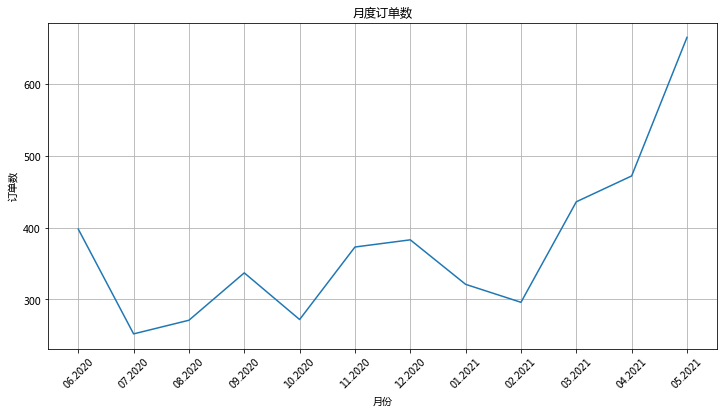

In [5]:
# 构建月度的订单数的DataFrame
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()

# 设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份')
ax.set_ylabel('订单数')
ax.set_title('月度订单数')

# 设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)

plt.show()


### 数据清洗


In [6]:
df_sales.isna().sum()
df_sales = df_sales.drop_duplicates()
df_sales = df_sales.loc[df_sales['数量'] > 0]

### 特征工程

先用前 3 个月的 R、F、M 值作为特征字段，然后把整个 12 个月的消费金额视为 LTV，作为标签字段。

#### 计算总价

In [7]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价']
df_sales.head()

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


#### 构建用户表

In [8]:
df_user = pd.DataFrame(df_sales['用户码'].unique())
df_user.columns = ['用户码']
df_user = df_user.sort_values(by='用户码', ascending=True).reset_index(drop=True)
df_user

,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
964,16015
965,16016
966,16017
967,16018


#### 构建特征集

把头 3 个月的销售数据拆分出来，形成独立的 df_sales_3m 对象；

In [9]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')]
df_sales_3m.reset_index(drop=True)

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.40
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.60
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.20
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.50
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.50
...,...,...,...,...,...,...,...,...,...
14214,545190,22937,2020-08-29 15:32:00,产品说明掩码,6,18.00,15656,苏州,108.00
14215,545190,22722,2020-08-29 15:32:00,产品说明掩码,4,39.50,15656,苏州,158.00
14216,545190,22457,2020-08-29 15:32:00,产品说明掩码,60,3.00,15656,苏州,180.00
14217,545190,22464,2020-08-29 15:32:00,产品说明掩码,12,25.00,15656,苏州,300.00


创建以用户码为主键的 df_user_LTV 对象，利用头 3 个月的数据，构建 R、F、M 层级，形成新特征。


In [10]:
df_user_LTV = pd.DataFrame(df_sales['用户码'].unique())
df_user_LTV.columns = ['用户码']
df_user_LTV.head()

df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index()
df_R_value.columns = ['用户码','最近购买日期']
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days
df_user_LTV = pd.merge(df_user_LTV, df_R_value[['用户码','R值']], on='用户码')

df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index()
df_F_value.columns = ['用户码','F值']
df_user_LTV = pd.merge(df_user_LTV, df_F_value[['用户码','F值']], on='用户码')

df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index()
df_M_value.columns = ['用户码','M值']
df_user_LTV = pd.merge(df_user_LTV, df_M_value, on='用户码')

df_user_LTV

,用户码,R值,F值,M值
0,15100,49,3,876.00
1,15291,41,33,1372.19
2,14688,6,82,1491.37
3,15311,5,693,12859.50
4,15862,89,64,354.23
...,...,...,...,...
356,15951,1,22,375.17
357,14745,1,7,240.60
358,15724,0,5,103.65
359,15874,0,5,584.35


#### 构建标签集

根据一整年的数据计算出每一个用户的 LTV 值，也就是 12 个月的总消费金额。

In [11]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index()
df_user_1y.columns = ['用户码','年度LTV']
df_user_1y.head()
df_LTV = pd.merge(df_user_LTV, df_user_1y, on='用户码', how='left')
df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,49,3,876.00,876.00
1,15291,41,33,1372.19,4668.30
2,14688,6,82,1491.37,4949.83
3,15311,5,693,12859.50,59457.10
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
356,15951,1,22,375.17,375.17
357,14745,1,7,240.60,1220.26
358,15724,0,5,103.65,218.25
359,15874,0,5,584.35,4405.88


现在，在这个数据集中，R、F、M 值来自于头 3 个月收集的数据，是模型的特征；LTV 值来自于整年的数据，是模型的标签。这非常符合我们的目标：用短期数据，来预测用户的长期价值。

### 创建特征集和标签集

#### 创建特征集

In [12]:
X = df_LTV.drop(['用户码','年度LTV'],axis=1)
X.head()

,R值,F值,M值
0,49,3,876.00
1,41,33,1372.19
2,6,82,1491.37
3,5,693,12859.50
4,89,64,354.23


#### 创建标签集

In [13]:
y = df_LTV['年度LTV']
y.head()

0      876.00
1     4668.30
2     4949.83
3    59457.10
4      659.73
Name: 年度LTV, dtype: float64

### 拆分训练集、验证集和测试集

In [14]:
from sklearn.model_selection import train_test_split

# 先拆分训练集(70%)和其它集(30%)
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)

# 再把其它集拆分成验证集(50%)和测试集(50%) 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)


---
## 选择算法创建模型

“用户生命周期价值”是一种连续性数值，对这种连续性数值的预测，属于一个回归问题。

常见的回归算法如下：

|回归算法                           | 说明                   |
| :------------------------------ | ---------------------- |
| 线性回归                           | 利用线性回归方程的最小二乘函数，对一个或多个自变量和因变量之间的关系，进行建模的一种回归分析。 |
| 贝叶斯回归                         | 使用统计学中的贝叶斯推断（beyesian inference）方法求解线性回归（linear regression）模型。 |
| SVM 回归（SVR）                    | 通过 SVM 求解回归问题，就是找到一个回归平面，让一个集合的所有数据到该平面的距离最近。 |
| 决策树                             | 主要指 CART（classification and regression tree）算法，内部节点特征的取值为“是”或“否”，为二叉树结构。用决策树解决回归问题，就是根据特征向量来决定对应的输出值。 |
| 随机森林                           | 用多棵决策树组合而成的一种集成学习模型。                     |
| AdaBoost 和 XGBoost 等梯度提升算法 | 利用 Boosting 方法基于树模型建立的集成学习模型。             |
| 神经网络算法                       | 由一组相互连接的神经元构建出来的深度学习模型。               |

随机森林呢，就是由多棵决策树构成的集成学习算法。它既能用于分类问题，也能用于回归问题。而且无论是解决哪类问题，它都是相对优秀的算法。在训练模型的过程中，随机森林会构建多个决策树，如果解决的是分类问题，那么它的输出类别是由个别树输出的类别的众数而定；如果解决的是回归问题，那么它会对多棵树的预测结果进行平均。

关于集成学习，现在只需要知道，随机森林纠正了决策树过度拟合其训练集的问题，在很多情况下它都能有不错的表现。这里的“过拟合”，其实就是说模型对训练集的模拟过头了，反而不太适合验证集和测试集。


In [15]:
# 导入线性回归模型
from sklearn.linear_model import LinearRegression
# 导入决策树回归模型
from sklearn.tree import DecisionTreeRegressor
# 导入随机森林回归模型
from sklearn.ensemble import RandomForestRegressor
# 其它回归模型
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge

# 创建线性回归模型
model_lr = LinearRegression()
# 创建决策树回归模型
model_dtr = DecisionTreeRegressor()
# 创建随机森林回归模型
model_rfr = RandomForestRegressor()
# 额外的回归模型
model_svm = SVR()
model_bayesian = BayesianRidge()

---
## 训练模型


In [16]:
model_lr.fit(X_train, y_train)
model_dtr.fit(X_train, y_train)
model_rfr.fit(X_train, y_train)

model_svm.fit(X_train, y_train)
model_bayesian.fit(X_train, y_train)

BayesianRidge()

---
## 评估模型

用回归模型预测验证集


In [17]:
y_valid_preds_lr = model_lr.predict(X_valid)
y_valid_preds_dtr = model_dtr.predict(X_valid)
y_valid_preds_rfr = model_rfr.predict(X_valid)

y_valid_preds_svm = model_svm.predict(X_valid)
y_valid_preds_bayesian = model_bayesian.predict(X_valid)

随便选择一个数据，显示一下三个模型对这一行数据所预测的 LTV 值，以及该用户的 LTV 真值。

In [18]:
print('真值:', y_valid.iloc[2])
print('线性回归预测值:', y_valid_preds_lr[2])
print('决策树预测值:', y_valid_preds_dtr[2])
print('随机森林预测值:', y_valid_preds_rfr[2])
print('SVM 预测值:', y_valid_preds_svm[2])
print('朴素贝叶斯预测值:', y_valid_preds_bayesian[2])

真值: 14389.900000000007
线性回归预测值: 40.37660912835389
决策树预测值: 106.2
随机森林预测值: 202.00020000000012
SVM 预测值: 1230.5015672476252
朴素贝叶斯预测值: 182.97599465911003


可以看到，相对而言，对这个数据点来说，决策树和随机森林所预测的 y 值更接近真值。

当然，一个数据点接近真值完全不能说明问题，我们还是要用 R2、MSE 等评估指标在验证集上做整体的评估，比较模型的优劣。


In [19]:
#导入Sklearn评估模块
from sklearn.metrics import r2_score
# R平方 值越大越好
print('验证集上的 R平方 分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的 R平方 分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的 R平方 分数-随机森林: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

print('验证集上的 R平方 分数-SVM: %0.4f' % r2_score(y_valid, model_svm.predict(X_valid)))
print('验证集上的 R平方 分数-朴素贝叶斯: %0.4f' % r2_score(y_valid, model_bayesian.predict(X_valid)))

验证集上的 R平方 分数-线性回归: 0.2983
验证集上的 R平方 分数-决策树: 0.3596
验证集上的 R平方 分数-随机森林: 0.3472
验证集上的 R平方 分数-SVM: -0.1820
验证集上的 R平方 分数-朴素贝叶斯: 0.3111


不同方式评估模型

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

# 值越小越好
print('验证集上的 中值绝对误差 分数-线性回归: %0.4f' % median_absolute_error(y_valid, model_lr.predict(X_valid)))
print('验证集上的 中值绝对误差 分数-决策树: %0.4f' % median_absolute_error(y_valid, model_dtr.predict(X_valid)))
print('验证集上的 中值绝对误差 分数-随机森林: %0.4f' % median_absolute_error(y_valid, model_rfr.predict(X_valid)))
print('验证集上的 中值绝对误差 分数-SVM: %0.4f' % median_absolute_error(y_valid, model_svm.predict(X_valid)))
print('验证集上的 中值绝对误差 分数-朴素贝叶斯: %0.4f' % median_absolute_error(y_valid, model_bayesian.predict(X_valid)))
print('------')
print('验证集上的 均方误差 分数-线性回归: %0.4f' % mean_squared_error(y_valid, model_lr.predict(X_valid)))
print('验证集上的 均方误差 分数-决策树: %0.4f' % mean_squared_error(y_valid, model_dtr.predict(X_valid)))
print('验证集上的 均方误差 分数-随机森林: %0.4f' % mean_squared_error(y_valid, model_rfr.predict(X_valid)))
print('验证集上的 均方误差 分数-SVM: %0.4f' % mean_squared_error(y_valid, model_svm.predict(X_valid)))
print('验证集上的 均方误差 分数-朴素贝叶斯: %0.4f' % mean_squared_error(y_valid, model_bayesian.predict(X_valid)))


验证集上的 中值绝对误差 分数-线性回归: 757.0875
验证集上的 中值绝对误差 分数-决策树: 798.1450
验证集上的 中值绝对误差 分数-随机森林: 828.8634
验证集上的 中值绝对误差 分数-SVM: 1002.8237
验证集上的 中值绝对误差 分数-朴素贝叶斯: 718.2908
------
验证集上的 均方误差 分数-线性回归: 10657316.3310
验证集上的 均方误差 分数-决策树: 9727124.6225
验证集上的 均方误差 分数-随机森林: 9915397.6653
验证集上的 均方误差 分数-SVM: 17952311.0810
验证集上的 均方误差 分数-朴素贝叶斯: 10463919.5367


最后，我们在随机森林上面运行测试集，并绘制出预测值和真值之间的散点图：

Text(0.5, 1.0, '实际值 vs. 预测值')

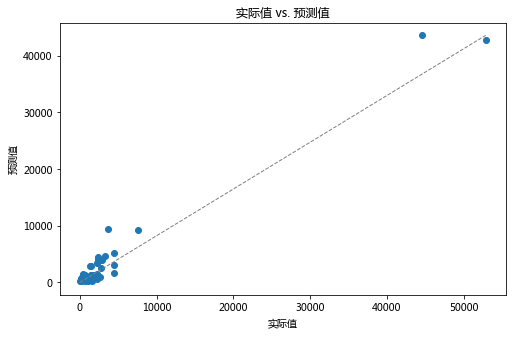

In [21]:
plt.figure(figsize = (8,5))

#用随机森林模型预测测试集
y_test_preds = model_rfr.predict(X_test)

#预测值和实际值的散点图
plt.scatter(y_test, y_test_preds)
plt.plot([0, max(y_test)], [0, max(y_test_preds)], color='gray', lw=1, linestyle='--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('实际值 vs. 预测值')

#### 绘制模型性能比较图

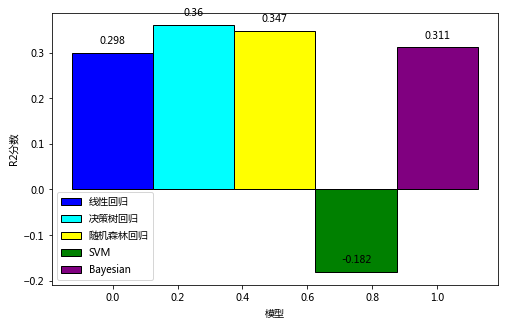

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
width = 0.25

# 柱子数据
bars1 = [r2_score(y_valid, model_lr.predict(X_valid))]
bars2 = [r2_score(y_valid, model_dtr.predict(X_valid))]
bars3 = [r2_score(y_valid, model_rfr.predict(X_valid))]

bars4 = [r2_score(y_valid, model_svm.predict(X_valid))]
bars5 = [r2_score(y_valid, model_bayesian.predict(X_valid))]
 
# 柱状图x轴位置
r1 = np.arange(len(bars1))
r2 = [x + width for x in r1]
r3 = [x + width*2 for x in r1]

r4 = [x + width*3 for x in r1]
r5 = [x + width*4 for x in r1]
 
# 柱状图
plt.bar(r1, bars1, width = width, color = 'blue', edgecolor = 'black', capsize=7, label='线性回归')
plt.bar(r2, bars2, width = width, color = 'cyan', edgecolor = 'black', capsize=7, label='决策树回归')
plt.bar(r3, bars3, width = width, color = 'yellow', edgecolor = 'black', capsize=7, label='随机森林回归')

plt.bar(r4, bars4, width = width, color = 'green', edgecolor = 'black', capsize=7, label='SVM')
plt.bar(r5, bars5, width = width, color = 'purple', edgecolor = 'black', capsize=7, label='Bayesian')

# 布局
# plt.xticks([r + width for r in range(len(bars1))], ['验证集'])
plt.ylabel('R2分数')
plt.xlabel('模型')
plt.legend(loc='lower left')

# 数值标签
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i/50+x[i], round(y[i], 3)+0.02, round(y[i], 3), ha = 'center')
addlabels(r1, bars1)
addlabels(r2, bars2)
addlabels(r3, bars3)

addlabels(r4, bars4)
addlabels(r5, bars5)
 
# 绘图
plt.show()

## 思考题

请你使用 Pandas 中的 get_dummies 这个工具，来添加“城市”相关的哑变量(dummy variable)，然后添加到特征集中，输入模型。


In [23]:
# 是否只使用前3个月的销售记录？
city = pd.get_dummies(df_sales_3m.城市, prefix='城市')
df_sales_3m = pd.concat([df_sales_3m, city], axis=1)

df_sales_3m

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价,城市_上海,城市_北京,城市_广州,城市_成都,城市_深圳,城市_苏州,城市_西安
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.40,0,1,0,0,0,0,0
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.60,1,0,0,0,0,0,0
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.20,1,0,0,0,0,0,0
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.50,0,1,0,0,0,0,0
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.50,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14837,545190,22937,2020-08-29 15:32:00,产品说明掩码,6,18.00,15656,苏州,108.00,0,0,0,0,0,1,0
14838,545190,22722,2020-08-29 15:32:00,产品说明掩码,4,39.50,15656,苏州,158.00,0,0,0,0,0,1,0
14839,545190,22457,2020-08-29 15:32:00,产品说明掩码,60,3.00,15656,苏州,180.00,0,0,0,0,0,1,0
14840,545190,22464,2020-08-29 15:32:00,产品说明掩码,12,25.00,15656,苏州,300.00,0,0,0,0,0,1,0


In [24]:
# df_C_value = df_sales_3m.groupby('用户码').agg({'城市_上海':'sum','城市_北京':'sum', '城市_广州': 'sum', '城市_成都': 'sum', '城市_深圳':'sum', '城市_苏州':'sum', '城市_西安':'sum'}) > 0
df_C_value = (df_sales_3m.groupby('用户码')[['城市_上海','城市_北京', '城市_广州', '城市_成都', '城市_深圳', '城市_苏州', '城市_西安']].sum() > 0)
df_LTV = pd.merge(df_LTV, df_C_value, on='用户码')
df_LTV

,用户码,R值,F值,M值,年度LTV,城市_上海,城市_北京,城市_广州,城市_成都,城市_深圳,城市_苏州,城市_西安
0,15100,49,3,876.00,876.00,False,True,False,False,False,False,False
1,15291,41,33,1372.19,4668.30,True,False,False,False,False,False,False
2,14688,6,82,1491.37,4949.83,False,True,False,False,False,False,False
3,15311,5,693,12859.50,59457.10,True,False,False,False,False,False,False
4,15862,89,64,354.23,659.73,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
356,15951,1,22,375.17,375.17,False,False,True,False,False,False,False
357,14745,1,7,240.60,1220.26,False,True,False,False,False,False,False
358,15724,0,5,103.65,218.25,False,False,False,False,False,True,False
359,15874,0,5,584.35,4405.88,False,False,False,False,True,False,False


因为增加了城市特征，需要重新从 **数据预处理>>创建特征集和标签集** 开始执行。

## 总结：

RFM主要用于观察老用户，然后促进在老用户身上的营收增长，精细化运营。

在拉新过程中，也就是起到一些估计指导意义，大概估计一批新用户有可能带来的平均回报吧。

对于回归问题来说，评估方法 R方 更常用，算是一个基本公认的比较好的标准吧。